In [28]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
from collections import Counter
import random
import statsmodels.api as sm
from scipy import optimize
%matplotlib inline

import matplotlib.font_manager as font_manager
path = '/Users/zhicongchen/msyh.ttf'
fontprop = font_manager.FontProperties(fname=path)

In [29]:
df = pd.read_csv('./attentionflow/20161220_attention.csv')

In [3]:
len(df)

90494

In [4]:
df['duration'].max() / 1000 / 3600.0

19.393888888888888

In [5]:
# duration in millisecond
df.sort_values(by='duration', ascending=False).head()

,uid,book_id,duration,startingtime
18834,1067627078,8abb00eb02d276a200292ef7,69818999,2016-12-20 00:00:31
25036,1300212410,b62377fa680203d8cf2f243d,65099795,2016-12-20 00:00:10
56881,2235686647,4cabedb567ec102de3bd897d,64469521,2016-12-20 00:00:04
47433,1944679359,72778d44ee06eff9aff80721,63932528,2016-12-20 00:00:10
19938,1098625270,49f598f452d380eb63946d83,61322509,2016-12-20 02:52:31


In [6]:
len(df['duration'][df['duration'] > 24*60*60*1000])

0

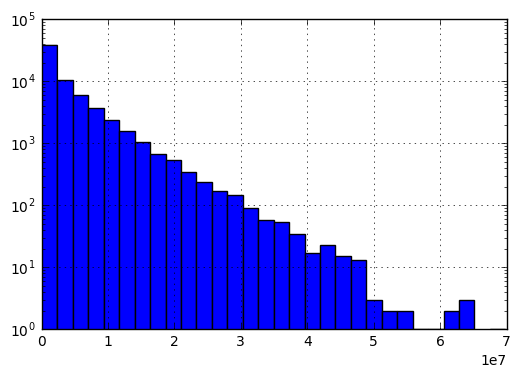

In [7]:
df['duration'][df['duration'] > 60*1000].hist(bins=30)
plt.yscale('log')
# plt.xscale('log')
# 有人一天内阅读时间超过4000，出现异常数据

In [8]:
book_df = pd.read_csv('./book.txt', delimiter=',', names=['book_id', 'book_name'])

In [9]:
len(book_df)

280376

In [10]:
len(set(df['book_id']) & set(book_df['book_id']))

15270

In [11]:
df = df.merge(book_df, left_on='book_id', right_on='book_id')
# , how='left' ?

In [12]:
len(df['book_id'].drop_duplicates())

15270

In [13]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84201 entries, 0 to 84200
Data columns (total 5 columns):
uid             84201 non-null int64
book_id         84201 non-null object
duration        84201 non-null int64
startingtime    84201 non-null object
book_name       84201 non-null object
dtypes: int64(2), object(3)
memory usage: 3.9+ MB


,uid,book_id,duration,startingtime,book_name
0,321636,d7eb5e27a45177232e60a20a,17730,2016-12-20 02:37:35,糖溪帮探险记第1季：意外大营救
1,321636,d7eb5e27a45177232e60a20a,765408,2016-12-20 03:41:16,糖溪帮探险记第1季：意外大营救
2,321636,e6deb0ced4d8d15abf234e2f,3813,2016-12-20 02:37:50,糖溪帮探险记第1季：地下藏身处
3,321636,e6deb0ced4d8d15abf234e2f,735349,2016-12-20 03:00:31,糖溪帮探险记第1季：地下藏身处
4,321636,dcffc4a4998fcc22bdd10d2e,1328615,2016-12-20 02:37:58,糖溪帮探险记第1季：湖上奇遇大狗鱼


In [14]:
len(df), len(df.dropna()), len(df['book_id'].drop_duplicates())

(84201, 84201, 15270)

# Attention Flow Network
每天的数据都搞成一个流网络：
book-book-duration(csv)

先用一天的数据，建立起一整个网络，描述一下这个网络的特性（小世界属性、度分布等等）

流距离（FromSource）与书的销量之间的关系（是否可以预测）

刻画碎片化阅读的规律
- 一个人在一天中读多少本书
- 多长时间算是在阅读？
- 多长时间算是在碎片化阅读？

文献
- 注意力的耗散
- attention dynamics

## build network

In [15]:
d = np.array(df[['uid', 'book_name']])
d[:5]

array([[321636,
        '\xe7\xb3\x96\xe6\xba\xaa\xe5\xb8\xae\xe6\x8e\xa2\xe9\x99\xa9\xe8\xae\xb0\xe7\xac\xac1\xe5\xad\xa3\xef\xbc\x9a\xe6\x84\x8f\xe5\xa4\x96\xe5\xa4\xa7\xe8\x90\xa5\xe6\x95\x91'],
       [321636,
        '\xe7\xb3\x96\xe6\xba\xaa\xe5\xb8\xae\xe6\x8e\xa2\xe9\x99\xa9\xe8\xae\xb0\xe7\xac\xac1\xe5\xad\xa3\xef\xbc\x9a\xe6\x84\x8f\xe5\xa4\x96\xe5\xa4\xa7\xe8\x90\xa5\xe6\x95\x91'],
       [321636,
        '\xe7\xb3\x96\xe6\xba\xaa\xe5\xb8\xae\xe6\x8e\xa2\xe9\x99\xa9\xe8\xae\xb0\xe7\xac\xac1\xe5\xad\xa3\xef\xbc\x9a\xe5\x9c\xb0\xe4\xb8\x8b\xe8\x97\x8f\xe8\xba\xab\xe5\xa4\x84'],
       [321636,
        '\xe7\xb3\x96\xe6\xba\xaa\xe5\xb8\xae\xe6\x8e\xa2\xe9\x99\xa9\xe8\xae\xb0\xe7\xac\xac1\xe5\xad\xa3\xef\xbc\x9a\xe5\x9c\xb0\xe4\xb8\x8b\xe8\x97\x8f\xe8\xba\xab\xe5\xa4\x84'],
       [321636,
        '\xe7\xb3\x96\xe6\xba\xaa\xe5\xb8\xae\xe6\x8e\xa2\xe9\x99\xa9\xe8\xae\xb0\xe7\xac\xac1\xe5\xad\xa3\xef\xbc\x9a\xe6\xb9\x96\xe4\xb8\x8a\xe5\xa5\x87\xe9\x81\x87\xe5\xa4\xa7\xe7\x8b\x97\x

In [26]:
def constructFlowNetwork (C):
    E=defaultdict(lambda:0)
    E[('source',C[0][1])]+=1
    E[(C[-1][1],'sink')]+=1
    F=zip(C[:-1],C[1:])
    for i in F:
        if i[0][0]==i[1][0]:
            E[(i[0][1],i[1][1])]+=1
        else:
            E[(i[0][1],'sink')]+=1
            E[('source',i[1][1])]+=1
    G=nx.DiGraph()
    for i,j in E.items():
        x,y=i
        G.add_edge(x,y,weight=j)
    return G
G = constructFlowNetwork(d)

In [27]:
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 14921
Number of edges: 30508
Average in degree:   2.0446
Average out degree:   2.0446


In [18]:
print df.uid.unique().size, df.book_id.unique().size

41714 15270


In [19]:
nx.write_gexf(G, "20161220.gexf")

## read network

In [20]:
G = nx.read_gexf('./20161220.gexf')

## Visualization

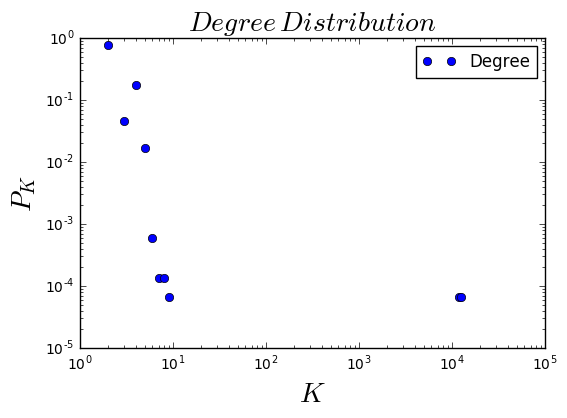

In [21]:
def plotDegreeDistribution(G):
    from collections import defaultdict
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    degs = defaultdict(int)
    for i in G.degree().values(): degs[i]+=1
    items = sorted ( degs.items () )
    x, y = np.array(items).T
    y = [float(i) / sum(y) for i in y]
    plt.plot(x, y, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.xlabel('$K$', fontsize = 20)
    plt.ylabel('$P_K$', fontsize = 20)
    plt.title('$Degree\,Distribution$', fontsize = 20)
    plt.show()
    
plotDegreeDistribution(G)

In [40]:
def attention_network_visualization(G):
    random_color = "#99cc%x%x" % (random.randint(0, 15), random.randint(0, 15))

    centrality = nx.degree_centrality(G)
    part = sorted(centrality.values(), reverse=True)[:20]
    node_size = []
    edge_width = []
    labels = {}  
    for i in G.nodes():
        node_size.append(centrality[i] * 500)
        if centrality[i] in part:
            labels[i] = i

    for i in G.edges():
        edge_width.append(G[i[0]][i[1]]['weight'])

    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=None, node_size=node_size, node_color='g', node_shape='o', alpha=1.0, cmap=None, vmin=None, vmax=None, ax=None, linewidths=None, label=None)
    nx.draw_networkx_edges(G, pos, edgelist=None, width=1.0, edge_color=random_color, style='solid', alpha=1.0, edge_cmap=None, edge_vmin=None, edge_vmax=None, ax=None, arrows=True, label=None)
    nx.draw_networkx_labels(G, pos, labels=labels, fontproperties=fontprop, font_size=10, font_color='k', font_family='Microsoft YaHei', font_weight='normal', alpha=1.0, ax=None)

    plt.axis('off')
    plt.show()
    
attention_network_visualization(G)

KeyboardInterrupt: 

In [ ]:
# 画一个人的
def one_attention_network_visualization(uid, df):
    G = nx.DiGraph()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
    user = df[df['uid'] == uid]
    G.add_path([e.decode('utf-8') for e in user['book_name']])
    for i in range(0, len(user)-1):
#         print user['book_name'][i], user['book_name'][i+1], user['duration'][i]
        G[user['book_name'].iloc[i].decode('utf-8')][user['book_name'].iloc[i+1].decode('utf-8')]['duration'] = float(user['duration'].iloc[i]) / 1000.0
    random_color = "#%x%xABCD" % (random.randint(0, 15), random.randint(0, 15))

    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=None, node_size=20, node_color=random_color, node_shape='o', alpha=1.0, cmap=None, vmin=None, vmax=None, ax=ax, linewidths=None, label=None)
    nx.draw_networkx_edges(G, pos, edgelist=None, width=1.0, edge_color=random_color, style='solid', alpha=1.0, edge_cmap=None, edge_vmin=None, edge_vmax=None, ax=ax, arrows=True, label=None)
    nx.draw_networkx_labels(G, pos, labels=None, fontproperties=fontprop, font_size=10, font_color='k', font_family='Microsoft YaHei', font_weight='normal', alpha=1.0, ax=ax)

    ax.set_title(str(uid))
    ax.set_axis_off()
    
    plt.show()
    
one_attention_network_visualization(2274112053, df)

In [ ]:
# 画时间的演变
# 9张图
def attention_network_visualization(uids, df):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharey=True)
    row = 0; col = 0
    while(1):
        G = nx.DiGraph()
        ax = axes[row, col]
            
        uid = uids[random.random()*len(uids)]
        user = df[df['uid'] == uid]
        if len(user) > 5:
            print 'uid: ', uid, 'len(user): ', len(user)
            G.add_path([e.decode('utf-8') for e in user['book_name']])
            for i in range(0, len(user)-1):
        #         print user['book_name'][i], user['book_name'][i+1], user['duration'][i]
                G[user['book_name'].iloc[i].decode('utf-8')][user['book_name'].iloc[i+1].decode('utf-8')]['duration'] = float(user['duration'].iloc[i]) / 1000.0

        
            random_color = "#%x%xABCD" % (random.randint(0, 15), random.randint(0, 15))

            pos = nx.spring_layout(G)
            nx.draw_networkx_nodes(G, pos, nodelist=None, node_size=20, node_color=random_color, node_shape='o', alpha=1.0, cmap=None, vmin=None, vmax=None, ax=ax, linewidths=None, label=None)
            nx.draw_networkx_edges(G, pos, edgelist=None, width=1.0, edge_color=random_color, style='solid', alpha=1.0, edge_cmap=None, edge_vmin=None, edge_vmax=None, ax=ax, arrows=True, label=None)
            nx.draw_networkx_labels(G, pos, labels=None, fontproperties=fontprop, font_size=10, font_color='k', font_family='Microsoft YaHei', font_weight='normal', alpha=1.0, ax=ax)

            ax.set_title(str(uid))
            ax.set_axis_off()
            
            col += 1
            if col == 3:
                col = 0; row += 1
                
        if row == 3:
            break
    
    plt.show()
    
attention_network_visualization(uids, attention_merge.dropna())

## Flow Distance

### flow balancing

In [67]:
# indegree = G.in_degree()
# outdegree = G.out_degree()

# for i in G.nodes():
#     if indegree[i] == 0:
#         G.add_edge('source', i, {'duration':0})
#     if outdegree[i] == 0:
#         G.add_edge(i, 'sink', {'duration':0})

In [71]:
# def flowBalancing(G):
#     RG = G.reverse()
#     H = G.copy()
#     def nodeBalancing(node):
#         outw=0
#         for i in G.edges(node):
#             outw+=G[i[0]][i[1]].values()[0]
#         inw=0
#         for i in RG.edges(node):
#             inw+=RG[i[0]][i[1]].values()[0]
#         deltaflow=inw-outw
#         if deltaflow > 0:
#             H.add_edge(node, "sink",weight=deltaflow)
#         elif deltaflow < 0:
#             H.add_edge("source", node, weight=abs(deltaflow))
#         else:
#             pass
#     for i in G.nodes():
#         nodeBalancing(i)
#     if ("source", "source") in H.edges():  H.remove_edge("source", "source")    
#     if ("sink", "sink") in H.edges(): H.remove_edge("sink", "sink")
#     return H

# G_balanced = flowBalancing(G)

In [29]:
def flowBalancing(G):
    H = G.copy()
    O = G.out_degree(weight='weight')
    I = G.reverse().out_degree(weight='weight')
    for i in O:
        if i =='sink' or i=='source':
            continue
        de = I[i]-O[i]
        if de > 0:
            H.add_edge(i,'sink',weight=de)
        if de < 0:
            H.add_edge('source',i,weight=-de)
    return H

G_balanced = flowBalancing(G)

In [23]:
print nx.info(G_balanced)

Name: 
Type: DiGraph
Number of nodes: 14921
Number of edges: 30508
Average in degree:   2.0446
Average out degree:   2.0446


### Flow Distance From Source

In [30]:
def flowDistanceFromSource(G): #input a balanced nx graph
    R = G.reverse()
    mapping = {'source':'sink','sink':'source'} 
    H = nx.relabel_nodes(R,mapping)
    #---------initialize flow distance dict------
    L = dict((i,1) for i in G.nodes())
    #---------prepare weighted out-degree dict------
    T = G.out_degree(weight='weight')
    #---------iterate until converge------------
    ls = np.array(L.values())
    delta = len(L)*0.01 + 1
    while delta > len(L)*0.01:
        for i in L:
            l=1
            for m,n in H.edges(i):
                l+=L[n]*H[m][n].values()[0]/float(T[m])
            L[i]=l
        delta = sum(np.abs(np.array(L.values()) - ls))
        ls = np.array(L.values())
    #---------clean the result-------
    del L['sink']
    for i in L:
        L[i]-=1
    L['sink'] = L.pop('source')
    return L

L = flowDistanceFromSource(G_balanced)

In [31]:
for i in L.keys()[:10]:
    print i, L[i]

人脉是设计出来的 1.0
恋上名门千金 2.0
天才宝宝：负心爹地，妈咪不要！ 1.0
神医之娇娘种田 1.0
减肥是一种修行 3.0
曾国藩·大全集 1.33332824707
盛开·第十六届新概念获奖者作品范本·小说卷 1.0
毒步后宫：谋妃狠妖娆 1.0
我曾爱你那么多 1.10465116211
七夜宠姬 1.0


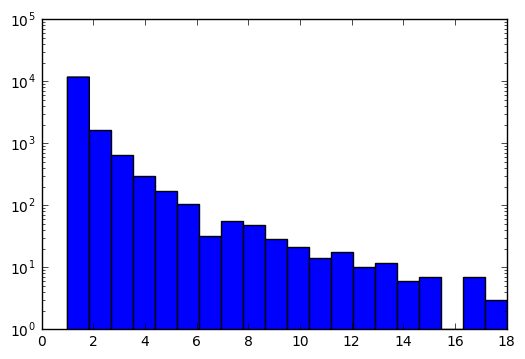

In [32]:
plt.hist(L.values(), bins=20)
plt.yscale('log')
# plt.xscale('log')
# 加一条拟合的曲线？

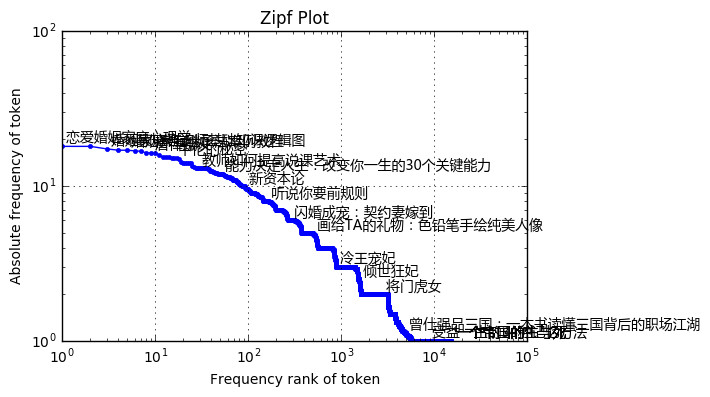

In [56]:
def plot_rank_frequency(L):
    counts = np.array(L.values())
    tokens = L.keys()

    # A Zipf plot
    ranks = np.arange(1, len(counts)+1)
    indices = np.argsort(-counts)
    frequencies = counts[indices]
    plt.loglog(ranks, frequencies, marker=".")
    plt.title("Zipf Plot")
    plt.xlabel("Frequency rank of token")
    plt.ylabel("Absolute frequency of token")
    plt.grid(True)
    for n in list(np.logspace(-0.5, np.log10(len(counts)), 20).astype(int)):
        dummy = plt.text(ranks[n-1], frequencies[n-1], " " + tokens[indices[n-1]].decode('utf-8'), 
                     verticalalignment="bottom",
                     horizontalalignment="left", fontproperties=fontprop)

    
plot_rank_frequency(L)

In [76]:
import math
for i in L.keys():
    if math.isinf(L[i]):
        print 'inf:', i, L[i]
    if math.isnan(L[i]):
        print 'NaN:', i, L[i]

### Flow Distance vs.
- Sales
- Duration

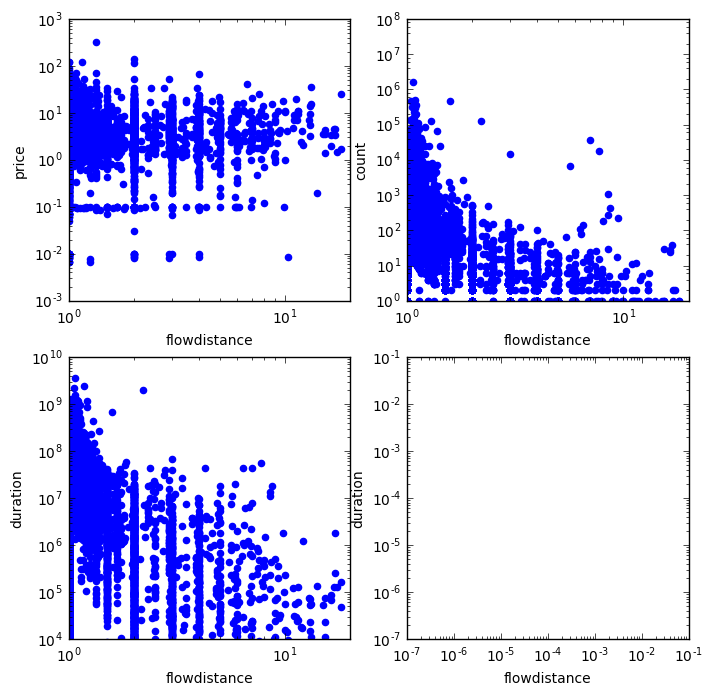

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=False, sharex=False)

sell_df = pd.read_csv('./doc_data.txt', delimiter='\t', names = ['book_name', 'book_id', 'user', 'buy_time', 'price'])
attributes = df.merge(sell_df[['book_id', 'price']], on='book_id').groupby('book_name').mean()['price']
book = list(set(L.keys()) & set([i for i in attributes.index]))
for i in book:
    axes[0,0].scatter(L[i], attributes[i], color='b')
        
attributes = df.merge(sell_df[['book_id', 'price']], on='book_id').groupby('book_name').count()['price']
for i in book:
    axes[0,1].scatter(L[i], attributes[i], color='b')
        
attributes = df.groupby('book_name').sum()['duration']       
for i in book:
    axes[1,0].scatter(L[i], attributes[i], color='b')
        
# if L[i] < float(10):
#     axes[1,1].scatter(L[i], duration_sum[i.encode('utf-8')], color='b')
    
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')
axes[0,0].set_xlabel('flowdistance')
axes[0,0].set_ylabel('price')
axes[0,0].set_xlim(1,20)
    
axes[0,1].set_yscale('log')
axes[0,1].set_xscale('log')
axes[0,1].set_xlabel('flowdistance')
axes[0,1].set_ylabel('readcount')
axes[0,1].set_xlim(1,20)
axes[0,1].set_ylim(1,10e7)

axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].set_xlabel('flowdistance')
axes[1,0].set_ylabel('duration')
axes[1,0].set_xlim(1,20)

axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_xlabel('flowdistance')
axes[1,1].set_ylabel('duration')

### Dissipation

In [33]:
def networkDissipate(G):
    D=defaultdict(lambda:[0,0,0])#toSink,totalflow,fromSource
    for x,y in G.edges():
        w = G[x][y].values()[0]
        if x == 'source':
            D[y][2]+=w
        elif y == 'sink':
            D[x][0]+=w
        elif x != 'source':
            D[x][1]+=w    
    return D

di = networkDissipate(G_balanced)

In [34]:
toSink,totalflow,fromSource = np.array(di.values()).T

In [35]:
toflow = totalflow-toSink

In [36]:
def log_binning(x, y, bin_count=20):
    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    xx = [i for i in x if i>0]
    min_x = np.log10(np.min(xx))
    bins = np.logspace(min_x,max_base,num=bin_count)
    bin_means_y = (np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0])
    bin_means_x = (np.histogram(x,bins,weights=x)[0] / np.histogram(x,bins)[0])
    return bin_means_x,bin_means_y

def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    ti, di = log_binning(xdata,ydata)
    x=np.log(ti+0.1);y=np.log(di+0.1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, alpha = 0.3)
    plt.plot(ti, di, 'ro')
    xs = np.linspace(min(ti+1),max(ti+1),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    plt.legend(loc = 0)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()

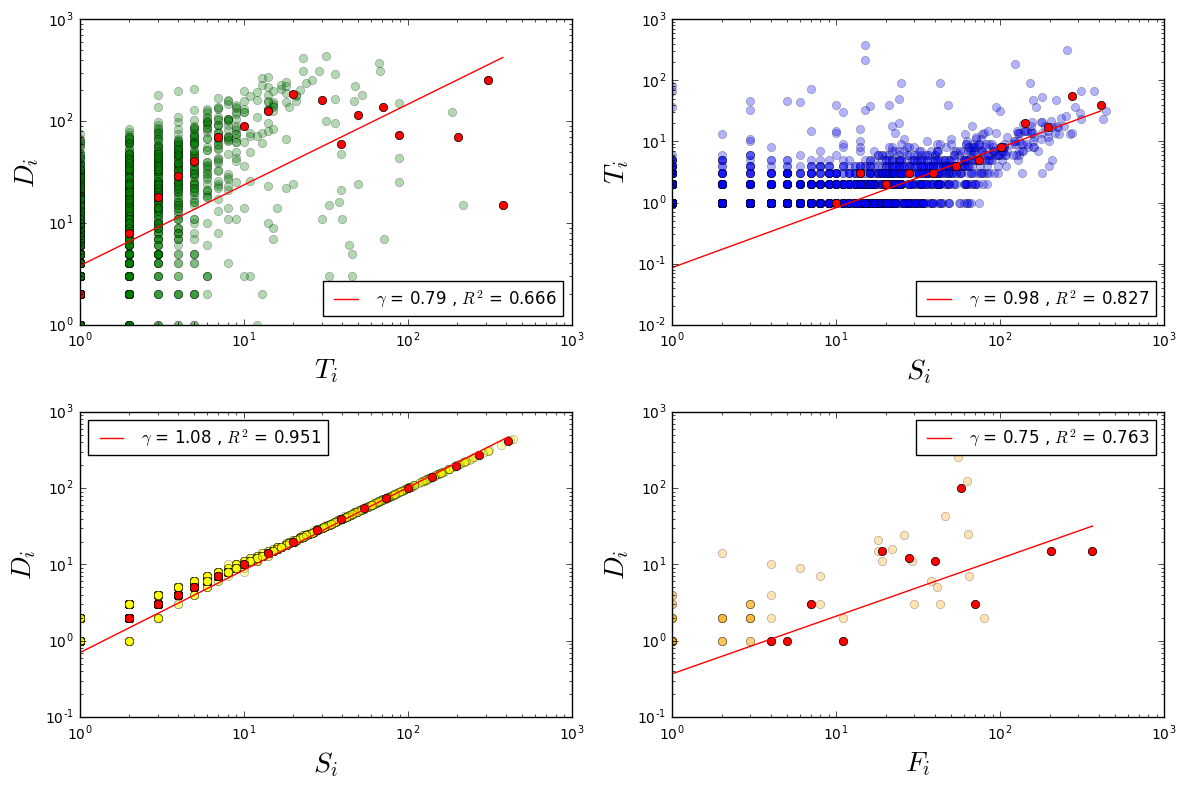

In [37]:
fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2,2,1)
alloRegressPlot(totalflow,toSink,'g','o','$T_i$','$D_i$', True)
ax = fig.add_subplot(2,2,2)
alloRegressPlot(fromSource,totalflow,'b','o','$S_i$','$T_i$', True)
ax = fig.add_subplot(2,2,3)
alloRegressPlot(fromSource,toSink,'yellow','o','$S_i$','$D_i$', True)
ax = fig.add_subplot(2,2,4)
alloRegressPlot(toflow,toSink,'orange','o','$F_i$','$D_i$', True)
plt.tight_layout()

### pv vs. uv

In [38]:
df['day'] = df['startingtime'].str[:10]

In [39]:
df.groupby('day')

In [40]:
pv = df.groupby('book_id').count()['uid']
uv = df.groupby('book_id')['uid'].nunique()

In [41]:
df.head()

,uid,book_id,duration,startingtime,book_name,day
0,321636,d7eb5e27a45177232e60a20a,17730,2016-12-20 02:37:35,糖溪帮探险记第1季：意外大营救,2016-12-20
1,321636,d7eb5e27a45177232e60a20a,765408,2016-12-20 03:41:16,糖溪帮探险记第1季：意外大营救,2016-12-20
2,321636,e6deb0ced4d8d15abf234e2f,3813,2016-12-20 02:37:50,糖溪帮探险记第1季：地下藏身处,2016-12-20
3,321636,e6deb0ced4d8d15abf234e2f,735349,2016-12-20 03:00:31,糖溪帮探险记第1季：地下藏身处,2016-12-20
4,321636,dcffc4a4998fcc22bdd10d2e,1328615,2016-12-20 02:37:58,糖溪帮探险记第1季：湖上奇遇大狗鱼,2016-12-20


In [42]:
df[df['book_id'] == 'd7eb5e27a45177232e60a20a']

,uid,book_id,duration,startingtime,book_name,day
0,321636,d7eb5e27a45177232e60a20a,17730,2016-12-20 02:37:35,糖溪帮探险记第1季：意外大营救,2016-12-20
1,321636,d7eb5e27a45177232e60a20a,765408,2016-12-20 03:41:16,糖溪帮探险记第1季：意外大营救,2016-12-20


In [43]:
pv['d7eb5e27a45177232e60a20a']

2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 5.291e+05
Date:                Wed, 26 Apr 2017   Prob (F-statistic):               0.00
Time:                        11:56:49   Log-Likelihood:                 1698.5
No. Observations:               15270   AIC:                            -3395.
Df Residuals:                   15269   BIC:                            -3387.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.0372      0.001    727.422      0.0

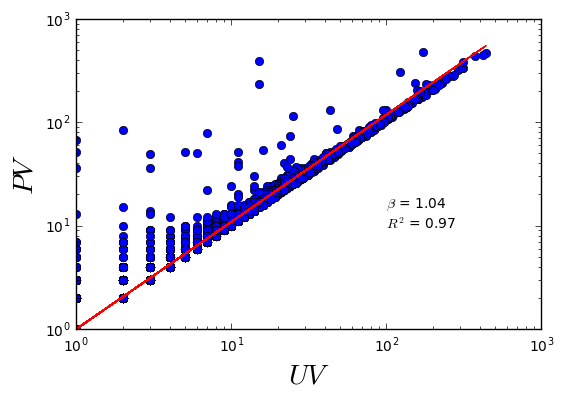

In [44]:
# without constant
X = np.log(np.array(uv))
y = np.log(np.array(pv))

results = sm.OLS(y, X).fit()
print results.summary()
beta = results.params
r2 = results.rsquared

plt.plot(np.exp(X), np.exp(y), 'bo')
plt.plot(np.exp(X[:-10]), np.exp(X[:-10] * beta), 'r-')

plt.xlabel(r'$UV$', fontsize=20)
plt.ylabel(r'$PV$', fontsize=20)
plt.text(100, 10, r'$\beta$ = ' + str(round(beta,2)) + '\n' + r'$R^2$ = ' + str(round(r2, 2)))
# plt.legend(loc=2, fontsize=10, numpoints=1)
plt.xscale('log')
plt.yscale('log')
plt.show()

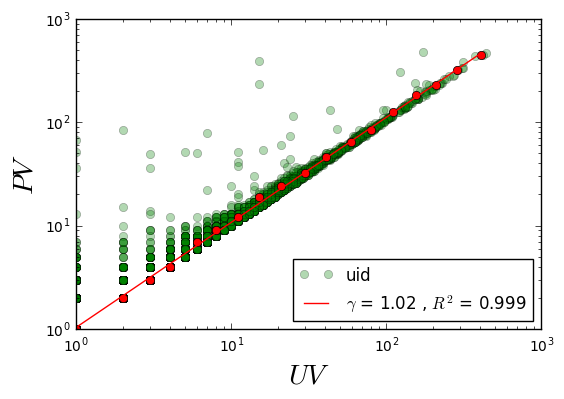

In [45]:
alloRegressPlot(uv,pv,'g','o','$UV$','$PV$', True)

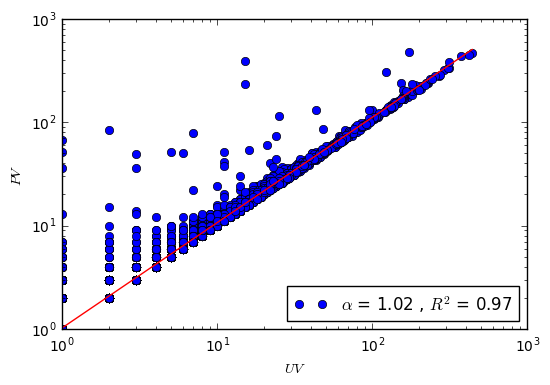

In [46]:
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, label='$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' + '$R^2$ = ' + str(np.round(r2,2)))
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab);plt.ylabel(ylab)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
#     plt.text(min(xdata)+(max(xdata)-min(xdata))/10,
#          min(ydata)+(max(ydata)-min(ydata))/2,
#          '$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' \
#          + '$R^2$ = ' + str(np.round(r2,2)) )
    plt.legend(loc=0)
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-')
    
alloRegressPlot(uv, pv, 'b', 'o', '$UV$', '$PV$', True)

In [ ]:
oneday_df = pd.read_csv('./20161220.txt', delimiter='\x01', names = ['uid', 'act_id', 'time', 'time_trigger', 'book_id', 'platform'])

In [ ]:
pv = oneday_df.groupby('book_id').count()['uid']
uv = oneday_df.groupby('book_id')['uid'].nunique()

In [ ]:
# add_constant
X = np.log(np.array(uv))
X1 = sm.add_constant(X)
y = np.log(np.array(pv))

results = sm.OLS(y, X1).fit()
print results.summary()
const, beta = results.params
r2 = results.rsquared
plt.plot(np.exp(X), np.exp(y), 'bo')
plt.plot(np.exp(X), np.exp(X * beta + const), 'r')

plt.xlabel(r'$UV$', fontsize=20)
plt.ylabel(r'$PV$', fontsize=20)
plt.text(100, 10, r'$\beta$ = ' + str(round(beta,2)) + '\n' + r'$R^2$ = ' + str(round(r2, 2)))
# plt.legend(loc=2, fontsize=10, numpoints=1)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Duration Distribution

In [85]:
df['minute'] = df['duration'] / 1000.0 / 60.0

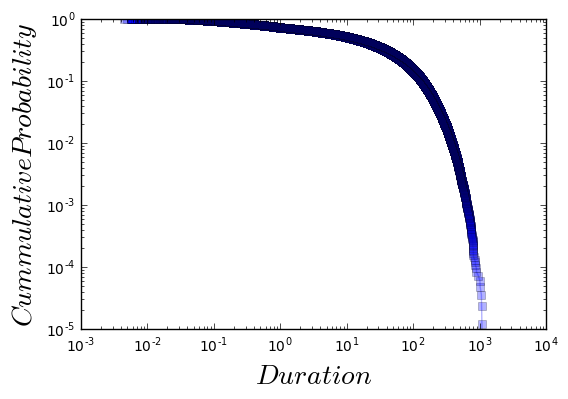

In [86]:
def cdf_plot(X):
    sorted_data = sorted(X, reverse=True)
    # yvals is not P(X)
    yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data,yvals,'bs-', alpha=0.3)
    # plt.xlim(min(sorted_data),max(sorted_data))
    plt.xlabel('$Duration$', fontsize = 20)
    plt.ylabel('$Cummulative Probability$', fontsize = 20)
    plt.xscale('log')
    plt.yscale('log')
cdf_plot(df['minute'])

[   1.34529089    0.22430672  132.88740615]
[[  1.90924121e-06  -9.41684625e-08  -1.13431274e-04]
 [ -9.41684625e-08   1.90140212e-08   2.48274323e-05]
 [ -1.13431274e-04   2.48274323e-05   5.05904084e-02]]


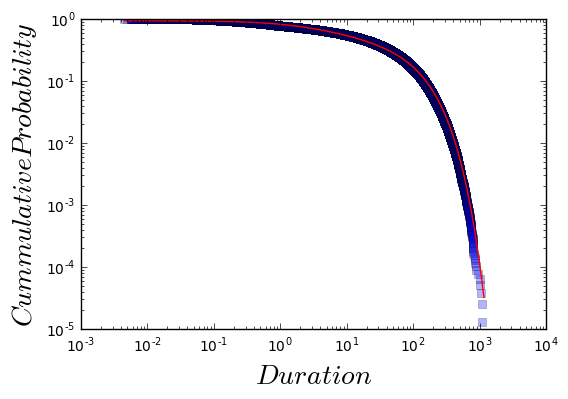

In [91]:
def func(rg, rg0, beta, K):
        return (rg + rg0) ** (-beta) * np.exp(-rg / K)

def parameter_estimate(rg):
#     rg = [round(i)+1 for i in rg]
    rg = np.unique(rg)
    rg = sorted(rg, reverse=True)
    rg = np.array(rg)
    prg = np.arange(len(rg)) / float(len(rg)-1)

    popt, pcov = optimize.curve_fit(func, rg, prg)
    print popt
    print pcov
    plt.plot(rg, prg, 'bs', alpha = 0.3)
    plt.plot(rg, [(i+popt[0])**-(popt[1])*np.exp(-i/popt[2]) for i in rg], 'r-')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$Duration$', fontsize = 20)
    plt.ylabel('$Cummulative Probability$', fontsize = 20)
    plt.show()
    
parameter_estimate(df['minute'])

In [2]:
from glob import glob
files = glob('./attentionflow/2016*.csv')
files[0], len(files)

('./attentionflow/20161001_attention.csv', 81)

In [97]:
a_df = pd.read_csv(files[1])

In [98]:
a_df['minute'] = a_df['duration'] / 1000.0 / 60.0

[   1.33098754    0.26068581  169.8587759 ]
[[  1.74458147e-06  -1.11185534e-07  -2.02286453e-04]
 [ -1.11185534e-07   2.75795526e-08   5.41703875e-05]
 [ -2.02286453e-04   5.41703875e-05   1.75456600e-01]]


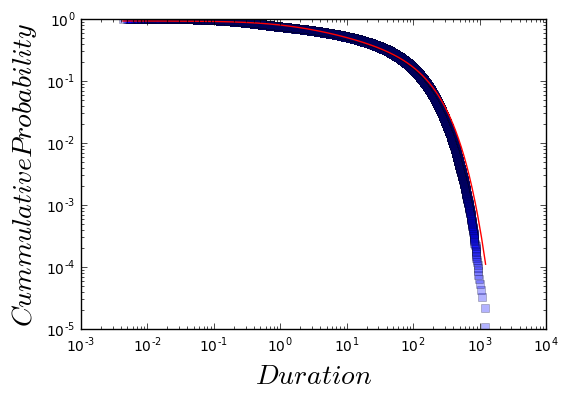

In [99]:
def func(rg, rg0, beta, K):
        return (rg + rg0) ** (-beta) * np.exp(-rg / K)

def parameter_estimate(rg):
#     rg = [round(i)+1 for i in rg]
    rg = np.unique(rg)
    rg = sorted(rg, reverse=True)
    rg = np.array(rg)
    prg = np.arange(len(rg)) / float(len(rg)-1)

    popt, pcov = optimize.curve_fit(func, rg, prg)
    print popt
    print pcov
    plt.plot(rg, prg, 'bs', alpha = 0.3)
    plt.plot(rg, [(i+popt[0])**-(popt[1])*np.exp(-i/popt[2]) for i in rg], 'r-')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$Duration$', fontsize = 20)
    plt.ylabel('$Cummulative Probability$', fontsize = 20)
    plt.show()
    
parameter_estimate(a_df['minute'])

# HHI(Herfindahl-Hirschman Index)

$HHI = \sum_{1}^{N}(X_i/X)^2 = \sum_{1}^{N}S_i^2$

- $X_i$ - 第i个企业的规模
- $X$ - 市场总规模
- $S_i$ - 市场占有率

In [141]:
X_duration = df['minute'].sum()
X_duration

3839520.621499993

In [143]:
X_i = df.groupby('book_name')['minute'].sum()
X_i[:10]

book_name
0~3岁婴幼儿营养配餐看这本就够了       16.354200
1/14第三季：死者的警告            0.073717
100个读到舌头抽筋也读不出来的绕口令      1.344317
10个案例说明什么是产品模型           0.566417
10分钟简便营养早餐               0.745567
10天学会手机摄影                6.464567
10天打造强大内心               19.276167
10天打造强大气场                6.946683
11处特工皇妃                861.688217
12岁决定孩子一生                9.823717
Name: minute, dtype: float64

In [144]:
HHI = ((np.array(X_i) / float(X_duration)) ** 2).sum()
HHI

0.0017251673700707326

In [149]:
X_duration = df['duration'].sum()
X_i = df.groupby('book_name')['duration'].sum()
HHI = ((np.array(X_i) / float(X_duration)) ** 2).sum()
print HHI

0.00172516737007


In [62]:
def herfindahl_hirschman_index(df):
    X_duration = df['duration'].sum()
    X_i = df.groupby('book_id')['duration'].sum()
    HHI = ((np.array(X_i) / float(X_duration)) ** 2).sum()
    return HHI

def herfindahl_hirschman_index_normalized(df):
    X_duration = df['duration'].sum()
    X_i = df.groupby('book_id')['duration'].sum()
    HHI = ((np.array(X_i) / float(X_duration)) ** 2).sum()
    N = len(X_i)
    HHI = (HHI - (1.0/N)) / (1 - 1.0/N)
    return HHI

In [64]:
print herfindahl_hirschman_index(df)
print herfindahl_hirschman_index_normalized(df)

0.0014419710537
0.00139242465948


In [23]:
hhi_list = []
for f in files:
    a_df = pd.read_csv(f)
    hhi_list.append(herfindahl_hirschman_index(a_df))

In [65]:
hhi_normalized_list = []
for f in files:
    a_df = pd.read_csv(f)
    hhi_normalized_list.append(herfindahl_hirschman_index_normalized(a_df))

In [33]:
files[20]

'./attentionflow/20161021_attention.csv'

In [43]:
a_df = pd.read_csv(files[20])

In [44]:
X_duration = a_df['duration'].sum()
S_i = a_df.groupby('book_id')['duration'].sum() / float(X_duration)

In [45]:
S_i.sort_values(ascending=False)[:10]

book_id
cdde71afa26925c52dc5bf31    0.029664
ac55534c81c758f5f71f6723    0.028059
8aba61b527d3240c8547efa5    0.020070
c68a105f647d27284b735173    0.016802
6c1507d2f78a6529657d53c2    0.014117
350b66a3482fb4daa58d4bd7    0.012018
2154ba98cc7931b765ce15b3    0.010079
34d0f4af25c52cc58ad6be71    0.008567
ca7a8c1bd4d8d15abf234e16    0.008531
567568f7a76e58fafbb00372    0.007576
Name: duration, dtype: float64

In [49]:
a_df = pd.read_csv(files[25])
X_duration = a_df['duration'].sum()
S_i = a_df.groupby('book_id')['duration'].sum() / float(X_duration)
S_i.sort_values(ascending=False)[:10]

book_id
83164ba8ddccda38376baffb    0.034899
cdde71afa26925c52dc5bf31    0.024456
6c1507d2f78a6529657d53c2    0.016219
350b66a3482fb4daa58d4bd7    0.011303
b77286f8c5da50e2534d7f0e    0.010189
f12b914b0722192e4536f6ac    0.009893
8b62cd30aa00b52acec7caa0    0.009728
c68b14987e21af45b207a8b9    0.008939
1decbcab5901020207409cbc    0.008872
feba636471fe910ef02df8bc    0.007722
Name: duration, dtype: float64

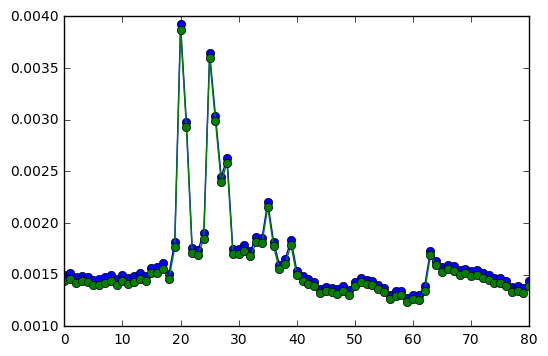

In [66]:
plt.plot(hhi_list, 'o-')
plt.plot(hhi_normalized_list, 'o-')

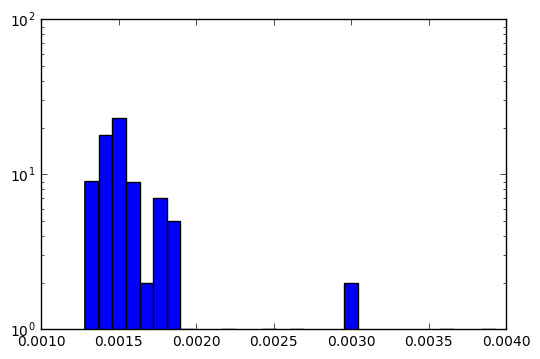

In [25]:
plt.hist(hhi_list, 30)
plt.yscale('log')

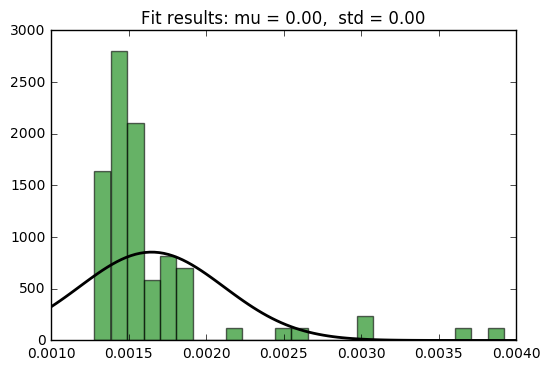

In [26]:
from scipy.stats import norm

# Fit a normal distribution to the data:
mu, std = norm.fit(hhi_list)
# Plot the histogram.
plt.hist(hhi_list, bins=25, normed=True, alpha=0.6, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

# Gini Coefficient

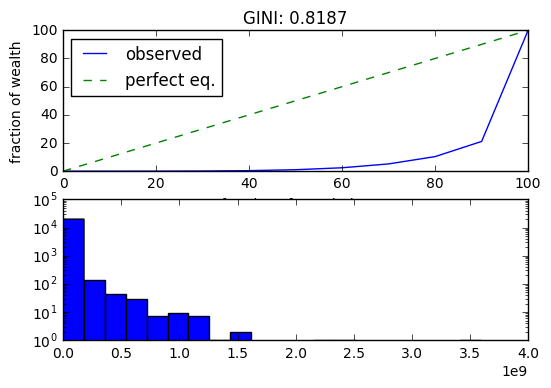

In [53]:
def gini_coefficient(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

v = df.groupby('book_id')['duration'].sum()
bins, result, gini_val = gini_coefficient(v)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("fraction of population")
plt.ylabel("fraction of wealth")
plt.title("GINI: %.4f" %(gini_val))
plt.legend(loc=0)
plt.subplot(2, 1, 2)
plt.hist(v, bins=20)
plt.yscale('log')

In [54]:
gini_list = []
for f in files:
    a_df = pd.read_csv(f)
    v = a_df.groupby('book_id')['duration'].sum()
    bins, result, gini_val = gini_coefficient(v)
    gini_list.append(gini_val)

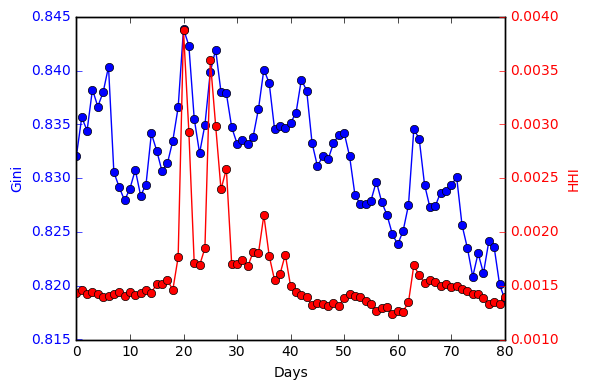

In [72]:
fig, ax1 = plt.subplots()
ax1.plot(gini_list, 'b-o')
ax1.set_xlabel('Days')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Gini', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(hhi_normalized_list, 'r-o')
ax2.set_ylabel('HHI', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

# Media Network

reach - 书的阅读人数

expected duplication - observed duplication



# Node2Vec

Node2Vec与流距离的关系？（张江-正相关）

Node2Vec建立起书在注意力网络中的位置（在几何空间中的映射）